In [1]:
import torch

import os

import pandas as pd
import scanpy as sc
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import cv2
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from sklearn.metrics import adjusted_rand_score

sc.set_figure_params(figsize=(6, 6))
import torch

import os

import pandas as pd
import scanpy as sc
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import cv2
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from sklearn.metrics import adjusted_rand_score

sc.set_figure_params(figsize=(6, 6))

In [2]:
def build_her2st_data(path, name, size=112):
    cnt_path = os.path.join(path, 'data/ST-cnts', f'{name}.tsv')
    df_cnt = pd.read_csv(cnt_path, sep='\t', index_col=0)

    pos_path = os.path.join(path, 'data/ST-spotfiles', f'{name}_selection.tsv')
    df_pos = pd.read_csv(pos_path, sep='\t')

    # lbl_path = os.path.join(path, 'data/ST-pat/lbl', f'{name}_labeled_coordinates.tsv')
    lbl_path = os.path.join(path, 'data/ST-pat/lbl', 'H1_labeled_coordinates.tsv')
    df_lbl = pd.read_csv(lbl_path, sep='\t')
    df_lbl = df_lbl.dropna(axis=0, how='any')
    # df_lbl.loc[df_lbl['label'] == 'undetermined', 'label'] = np.nan
    df_lbl['x'] = (df_lbl['x']+0.5).astype(np.int64)
    df_lbl['y'] = (df_lbl['y']+0.5).astype(np.int64)

    x = df_pos['x'].values
    y = df_pos['y'].values
    ids = []
    for i in range(len(x)):
        ids.append(str(x[i])+'x'+str(y[i])) 
    df_pos['id'] = ids

    x = df_lbl['x'].values
    y = df_lbl['y'].values
    ids = []
    for i in range(len(x)):
        ids.append(str(x[i])+'x'+str(y[i])) 
    df_lbl['id'] = ids

    meta_pos = df_cnt.join(df_pos.set_index('id'))
    meta_lbl = df_cnt.join(df_lbl.set_index('id'))

    adata = anndata.AnnData(df_cnt, dtype=np.int64)
    adata.obsm['spatial'] = np.floor(meta_pos[['pixel_x','pixel_y']].values).astype(int)
    adata.obs['label'] = pd.Categorical(meta_lbl['label']).codes
    adata.obs['label'] = adata.obs['label'].astype('category')
    
    img_path = os.path.join(path, 'data/ST-imgs', name[0], name)
    full_image = cv2.imread(os.path.join(img_path, os.listdir(img_path)[0]))
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    patches = []
    for x, y in adata.obsm['spatial']:
        patches.append(full_image[y - size:y+size, x-size:x+size])
    patches = np.array(patches)
    
    return adata, patches, full_image

In [3]:
path = 'D:/st_projects/her2st/'
name = 'H2'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adata, patches, full_images = build_her2st_data(path, name)
print(adata)

C:\Users\wangyu\.conda\envs\mucst\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 603 × 14907
    obs: 'label'
    obsm: 'spatial'


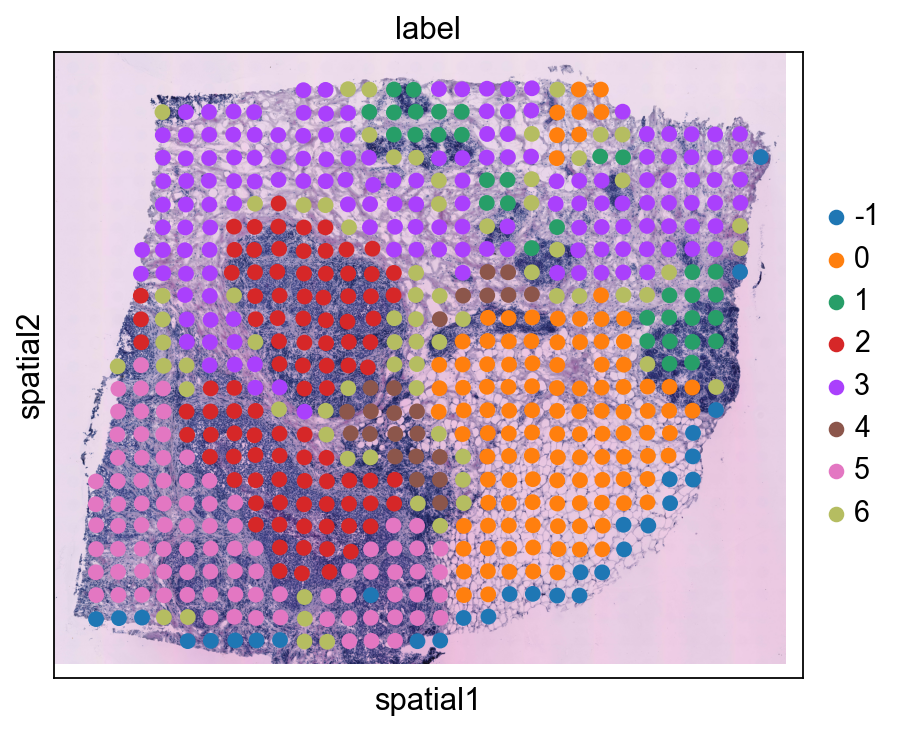

In [4]:
quality = 'hires'
scale = 1.0
spot_diameter_fullres = 50
library_id = name
adata.uns["spatial"] = dict()
adata.uns["spatial"][library_id] = dict()
adata.uns["spatial"][library_id]['images'] = dict()
adata.uns["spatial"][library_id]['images'][quality] = full_images
adata.uns["spatial"][library_id]["use_quality"] = quality
adata.uns["spatial"][library_id]['scalefactors'] = dict()
adata.uns["spatial"][library_id]['scalefactors']["tissue_" + quality + "_scalef"] = scale
adata.uns["spatial"][library_id]['scalefactors']['spot_diameter_fullres'] = spot_diameter_fullres

adata.obs[["imagecol", "imagerow"]] = adata.obsm["spatial"] * scale
sc.pl.spatial(adata, color='label', library_id=library_id, size=4, scale_factor=1.0)

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, zero_center=False, max_value=10)
adata

C:\Users\wangyu\.conda\envs\mucst\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:163: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


AnnData object with n_obs × n_vars = 603 × 2409
    obs: 'label', 'imagecol', 'imagerow', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'label_colors', 'hvg', 'log1p'
    obsm: 'spatial'

In [6]:
from pathlib import Path
from mucstpy.image_feature import image_crop
from mucstpy.image_feature import ImageFeature

save_path = 'results'
section = 'HER2_E1'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)
adata = image_crop(adata, save_path=save_path_image_crop, crop_size=512, verbose=False)
adata = ImageFeature(adata, pca_components=50, verbose=True, seeds=2023).extract_image_features()

C:\Users\wangyu\.conda\envs\mucst\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Tiling Image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


In [8]:
from mucstpy.utils import construction_interaction
from sklearn.metrics import pairwise_distances

k_nei = 8
construction_interaction(adata, n_neighbor=k_nei)
adj = adata.obsm['adj']

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

adj_spatial_mor = adj * morphological_similarity
adata.obsm['mor_adj'] = adj_spatial_mor

In [10]:
from mucstpy.utils import data_augmentation

data_augmentation(adata)

In [23]:
from mucstpy.MuCST import train_model
from mucstpy.utils import add_contrastive_label, get_feature

add_contrastive_label(adata)
get_feature(adata)

gene_dims=[adata.shape[1], 64]
img_dims=[adata.obsm['image_feature'].shape[1], 64]
project_dims=[64, 32, 16]

train_model(adata, gene_dims=gene_dims, img_dims=img_dims, proj_dims=project_dims, lamb1=0.5, device=device)

Begin to train MuCST...


# Epoch 1506, loss: 15.272, g2i_loss: 7.150, g2g_loss: 0.898, i2i_loss: 7.094, gene_recon: 0.934, image_recon: 0.010:  96%|█████████▋| 1494/1550 [00:07<00:00, 213.39it/s]

# Epoch 1500, loss: 15.594, g2g_loss: 0.871, gene_recon: 0.847, image_recon: 0.008
Init finished, start contrastive learning part


# Epoch 1549, loss: 14.857, g2i_loss: 6.824, g2g_loss: 0.861, i2i_loss: 7.087, gene_recon: 0.850, image_recon: 0.018: 100%|██████████| 1550/1550 [00:08<00:00, 174.70it/s]

Optimization of MuCST finished


In [24]:
from mucstpy.utils import search_res

res = search_res(adata, n_clusters=10, use_rep='fusion_pca', start=0.1, end=2.0)
sc.tl.leiden(adata, key_added='mucst_leiden', resolution=res)

Searching resolution...
resolution=1.989999999999999, cluster number=12
resolution=1.979999999999999, cluster number=12
resolution=1.969999999999999, cluster number=12
resolution=1.959999999999999, cluster number=12
resolution=1.949999999999999, cluster number=12
resolution=1.939999999999999, cluster number=12
resolution=1.9299999999999993, cluster number=12
resolution=1.9199999999999993, cluster number=11
resolution=1.9099999999999993, cluster number=11
resolution=1.8999999999999992, cluster number=11
resolution=1.8899999999999992, cluster number=12
resolution=1.8799999999999992, cluster number=11
resolution=1.8699999999999992, cluster number=11
resolution=1.8599999999999992, cluster number=11
resolution=1.8499999999999992, cluster number=12
resolution=1.8399999999999992, cluster number=12
resolution=1.8299999999999992, cluster number=11
resolution=1.8199999999999992, cluster number=11
resolution=1.8099999999999992, cluster number=11
resolution=1.7999999999999992, cluster number=11
re

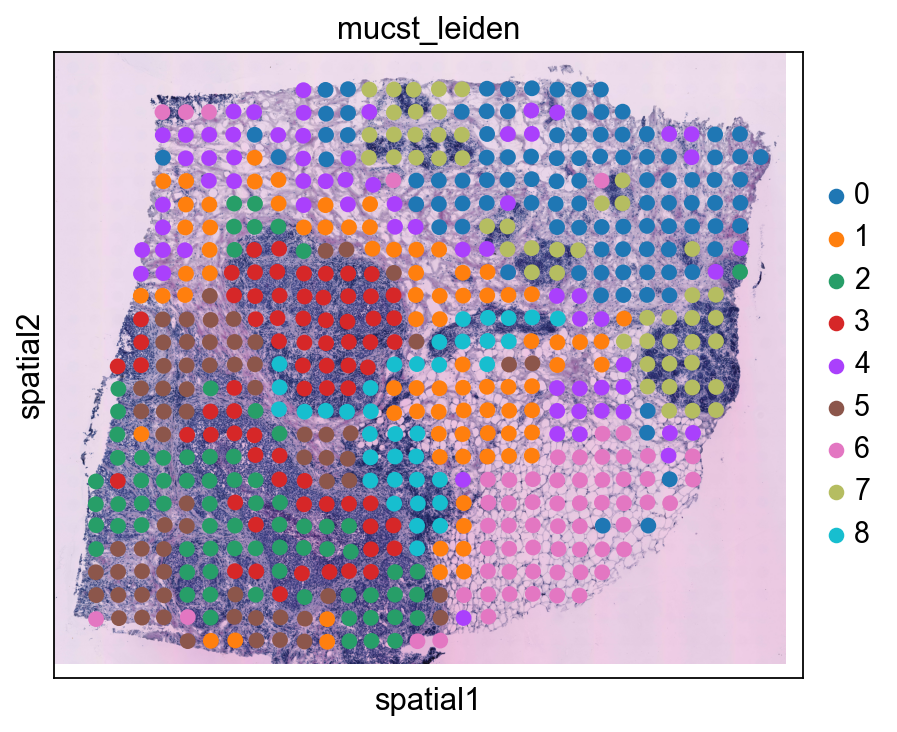

In [26]:
sc.tl.leiden(adata, key_added='mucst_leiden', resolution=1.2)
# sc.pl.embedding(adata, basis='spatial', color=['leiden_rec_feature', 'label'])
sc.pl.spatial(adata, color=['mucst_leiden'], library_id=library_id, size=4, scale_factor=1.0)